<a href="https://colab.research.google.com/github/kiru883/Kaggle-IEEE-CIS-Fraud-Detection/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
import joblib
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold
from sklearn.feature_selection import RFECV

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load dataset

In [0]:
#####LOAD DATASETS
# train
data_trainTR = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/train_transaction.csv")
data_trainID = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/train_identity.csv")

# test
data_testTR = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/test_transaction.csv")
data_testID = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/test_identity.csv") 

# Memory usage reduction function and etc.

In [0]:
#optimize memory
def reduce_mem_usage(df):
    mem_usage_before = np.around(df.memory_usage().sum() / 1028**2)
    print(f"Memory usage before: {mem_usage_before} MB")

    for column in df.columns:
        if df[column].dtype == 'float':
            mn, mx = df[column].min(), df[column].max()
            if mn > -2147483648 or mx < 2147483648:
                df[column] = df[column].astype('float32')

        elif df[column].dtype == 'int':
            mn, mx = df[column].min(), df[column].max()
            if mn > -128 or mx < 127:
                df[column] = df[column].astype('int8')
            elif mn > -32000 or mx < 32000:
                df[column] = df[column].astype('int16')
            elif mn > -2147483648 or mx < 2147483648:
                df[column] = df[column].astype('int32')

        elif df[column].dtype == 'object':
            df[column] = df[column].astype('category')

    mem_usage_after = np.around(df.memory_usage().sum() / 1028**2)
    print(f"Memory usage after: {mem_usage_after} MB")
    print(f"Optimization: {np.around(100*(1 - mem_usage_after/mem_usage_before))}%")

    return df

# validation score, TimeSeriesSplit(5 folds), KFolds(3 fold), 3/4 month train & 1/4 test score
def valid_scores(model, df_x, y):
    y = y.to_numpy().reshape(-1, 1)
    X = df_x.to_numpy()
    scores = dict()

    #TimeSeriesSplit 5
    TTS5 = TimeSeriesSplit()
    tts5_scores = []
    for train_ind, test_ind in TTS5.split(X):
        train_x, test_x = X[train_ind], X[test_ind]
        train_y, test_y = y[train_ind], y[test_ind]
        model.fit(train_x, train_y)
        tts5_scores.append(roc_auc_score(test_y, model.predict_proba(test_x)[:, 1]))
    scores['TTS5'] = sum(tts5_scores) / 5

    #KFolds 3
    KF3 = KFold(n_splits=3)
    kf3_scores = []
    for train_ind, test_ind in KF3.split(X):
        train_x, test_x = X[train_ind], X[test_ind]
        train_y, test_y = y[train_ind], y[test_ind]
        model.fit(train_x, train_y)
        kf3_scores.append(roc_auc_score(test_y, model.predict_proba(test_x)[:, 1]))
    scores['KF3'] = sum(kf3_scores) / 3

    #3/4 month train, last 1/4 test
    ind = 3*(len(X) // 4)
    train_x, test_x = X[:ind], X[ind:]
    train_y, test_y = y[:ind], y[ind:]
    model.fit(train_x, train_y)
    scores['Test3/4_kaggle'] = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])

    #print scores
    print("/"*30)
    for k in scores.keys():
        print(f"{k}: {scores[k]}")
    print(f"Avg. score: {sum(scores.values()) / len(scores)}")
    print("/"*30)

#get predict 
def get_predict(model, df, ids, name='predicted.csv'):
    pred = model.predict_proba(df.to_numpy())[:, 1]
    new_df = pd.concat([ids, pd.Series(data=pred)], axis=1)
    #new_df = new_df.drop('Unnamed: 0', axis=1)
    new_df.columns = ['TransactionID', 'isFraud']
    new_df.to_csv(name, index=False)


# Main pipeline

In [0]:
#with all my hypotises
def pipeline(data_TR, data_ID):
    #useful functions
    def decimal_places(x):
        decimal_str = str(x)[str(x).find(".") +1:]
        if decimal_str == "0":
            return 0
        decimal_len = len(str(int(decimal_str[::-1])))
        return decimal_len if decimal_len < 5 else 5
    
    def email_map(email):
        mapping= {'frontier.com':'frontier','frontiernet.net':'frontier','gmail':'gmail','gmail.com':'gmail','hotmail.co.uk':'hotmail','hotmail.com':'Microsoft','hotmail.de':'Microsoft',
            'hotmail.es':'Microsoft','hotmail.fr':'Microsoft','icloud.com':'Apple','live.com':'Microsoft','live.com.mx':'Microsoft','live.fr':'Microsoft','mac.com':'Apple',
            'netzero.com':'Netzero','netzero.net':'Netzero','outlook.com':'Microsoft','outlook.es':'Microsoft', 'yahoo.co.jp':'Yahoo','yahoo.co.uk':'Yahoo','yahoo.com':'Yahoo',
            'yahoo.com.mx':'Yahoo','yahoo.de':'Yahoo','yahoo.es':'Yahoo','yahoo.fr':'Yahoo','ymail.com':'Yahoo', 'scranton.edu':'Scranton'}
        if email in mapping.keys():
            return mapping[email]
        elif pd.isnull(email):
            return 'NAN'
        else:
            return 'other'

    def parse_id30(x):
        devices_30_list = ['windows', 'ios', 'mac', 'android', 'linux']
        if pd.isnull(x): 
            return 'NAN'
        elif x.split()[0].lower() in devices_30_list: 
            return x.split()[0].lower()
        else:
            return 'NAN'
        
    def parse_id31(x):
        devices_30_set = {'chrome', 'safari', 'ie', 'edge', 'firefox'}
        if pd.isnull(x): 
            return 'NAN'
        result = list(devices_30_set & set(x.split()))
        if len(result) == 0:
            return 'other'
        else:
            return result[0]
        
    def parse_id33(x):
        devices_33_list = ['1334x750', '2436x1125', '1366x768', '1920x1080', '2208x1242']
        if pd.isnull(x):
            return 'NAN'
        if x in devices_33_list:
            return x
        else:
            return 'other'
        
    def parse_deviceinfo(x):
        devices_info_list = ['windows', 'macos', 'ios', 'trident/7.0']
        if pd.isnull(x):
            return 'NAN'
        x = x.split()[0].lower()
        if x in devices_info_list:
            return x
        else:
            return 'other'

    df = pd.concat([data_TR.set_index('TransactionID'), data_ID.set_index('TransactionID')], axis=1).reset_index()
    del data_TR, data_ID

    #main pipeline
    df['month'] = df['TransactionDT'] // (86400 * 30)
    # transactionAmt features
    df['TransactionAmt'] = df['TransactionAmt'].fillna(-999)
    df['transaction_month'] = df.groupby(['month'])['TransactionAmt'].transform('mean') - df['TransactionAmt']
    df['trans_meanq'] = pd.qcut(df['TransactionAmt'].median() - df['TransactionAmt'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
    df['trans_std_negative'] = np.where((df['transaction_month'] < 0), 1, 0)
    df['transaction_std'] = df['transaction_month'] / df.groupby(['month'])['TransactionAmt'].transform('std')
    df['transaction_stdq'] = (df['TransactionAmt'].median() - df['TransactionAmt']) / df['TransactionAmt'].std()
    df['transaction_stdq'] = pd.qcut(df['transaction_stdq'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
    df['transaction_digits'] = df['TransactionAmt'].map(decimal_places)
    df['transaction_count'] = df['TransactionAmt'].map(df['TransactionAmt'].value_counts())
    df['transaction_count'] = pd.qcut(df['transaction_count'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
    high_tr = df['TransactionAmt'].quantile([0.9]).to_list()[0]
    lower_tr = df['TransactionAmt'].quantile([0.1]).to_list()[0]
    df['outlier'] = np.where((df['TransactionAmt'] > high_tr) | (df['TransactionAmt'] < lower_tr), 1, 0)
    df['trans_hour'] = (df['TransactionDT'] % 86400) // 3600
    df['trans_cent'] = df['TransactionAmt'] % 1

    #ProductCd
    df['ProductCD'] = df['ProductCD'].fillna('NAN')
    df['prod_stdq'] = pd.qcut(df.groupby(["ProductCD"])['TransactionAmt'].transform('median') - df['TransactionAmt'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
    df['ProductCD'] = LabelEncoder().fit_transform(df['ProductCD'])
    
    #card1
    df['card1'] = df['card1'].fillna(-999)
    df['card1_count'] = df['card1'].map(df['card1'].value_counts())
    df['card1_count_q'] = pd.qcut(df['card1_count'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
    df['card1_frequency'] = df['card1'].map(df['card1'].value_counts() / df['card1'].shape[0])
    df['card1_frequency'] = pd.qcut(df['card1_frequency'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
    df['trans_card1_mean'] = df.groupby(['card1'])['TransactionAmt'].transform('mean') - df['TransactionAmt']
    df['trans_card1_mean_rel'] = df.groupby(['card1'])['TransactionAmt'].transform('mean') / df['TransactionAmt']
    df['card1_mean'] = df.groupby(['month'])['card1'].transform('mean') - df['card1']
    df['card1_std'] = df.groupby(['month'])['card1'].transform('std') / df['card1_mean'] 
    df['card1_addr1_mean'] = df['card1'].astype('str') + '_' + df['addr1'].astype('str')
    df['card1_addr1_mean'] = df.groupby(['card1_addr1_mean'])['TransactionAmt'].transform('mean') - df['TransactionAmt']

    #card2
    df['card2'] = df['card2'].fillna(-999)
    df['card2_count'] = df['card2'].map(df['card2'].value_counts())
    df['card2_out'] = pd.qcut(df['card2_count'], [0.05, 0.15, 0.85, 0.95], labels=False).fillna(-1)
    df['card2_q'] = pd.qcut(df['card2_count'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)

    #card3
    df['card3'] = df['card3'].fillna(-999)
    df['card3_o'] = np.where((df['card3'] < df['card3'].quantile(0.1)) | (df['card3'] > df['card3'].quantile(0.9)), 1, 0)
    
    #card4
    df['card4'] = df['card4'].fillna('NAN')
    df['card4_count'] = df['card4'].map(df['card4'].value_counts())
    df['trans_card_mean'] = df.groupby(['card4'])['TransactionAmt'].transform('mean') - df['TransactionAmt']
    df['trans_card_mean_q'] = pd.qcut(df['trans_card_mean'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
    df['trans_card_std'] = df.groupby(['card4'])['TransactionAmt'].transform('std') / df['trans_card_mean']
    df['trans_card_std_q'] = pd.qcut(df['trans_card_std'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
    df['card4_trans_mean'] = df['TransactionAmt'].astype('str') + '_' + df['card4'].astype('str')
    df['card4_trans_mean'] = df.groupby(['card4_trans_mean'])['TransactionAmt'].transform('mean') - df['TransactionAmt']
    df['card4'] = LabelEncoder().fit_transform(df['card4'])

    #card5
    df['card5'] = df['card5'].fillna(-999)
    df['card5_o'] = np.where(((df['card5'] < df['card5'].quantile(0.05)) | (df['card5'] > df['card5'].quantile(0.95))), 1, 0)

    #card6
    df['card6'] = df['card6'].fillna('NAN')
    df['trans_card_med'] = df.groupby(['card6'])['TransactionAmt'].transform('median') - df['TransactionAmt']
    df['card6'] = LabelEncoder().fit_transform(df['card6'])

    #addr1
    df['addr1'] = df['addr1'].fillna(-999)
    df['addr1_isnull'] = df['addr1'].isnull().astype(int)
    df['addr1_frequency'] = df['addr1'].map(df['addr1'].value_counts())
    df['addr_trans'] = df.groupby(['addr1'])['TransactionAmt'].transform('median') - df['TransactionAmt']
    df['addr_trans_q'] = pd.qcut(df['addr_trans'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
    df['addr_card_med'] = df.groupby(['addr1'])['card1'].transform('median') - df['card1']
    df['addr_card'] = df.groupby(['addr1'])['card1'].transform('median') - df['card1']
    df['addr_card_q'] = pd.qcut(df['addr_card'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
    df['addrcard'] = df['addr1'].astype(str) + "_" + df['card1'].astype(str)
    df['addrcard'] = LabelEncoder().fit_transform(df['addrcard'])

    #addr2 & dist1 & dist2
    df['addr2'] = df['addr2'].fillna(-999)
    df['dist1'] = df['dist1'].fillna(-999)
    df['dist2'] = df['dist2'].fillna(-999)

    #p_emaildomain
    df['P_emaildomain'] = LabelEncoder().fit_transform(df['P_emaildomain'].map(email_map))

    #r_emaildomain
    df['R_emaildomain'] = LabelEncoder().fit_transform(df['R_emaildomain'].map(email_map))

    #Cs
    for Ci in range(1, 15):
        c = "C" + str(Ci)
        df[c] = df[c].fillna(-999)
        df[c + '_trans_div'] = df.groupby([c])['TransactionAmt'].transform('median') - df['TransactionAmt']
        df[c + '_trans_div_q'] = pd.qcut(df[c + '_trans_div'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)

    #Ds
    for Di in range(1, 16):
        d = "D" + str(Di)
        df[d] = df[d].fillna(-999)
    
    #Ms
    for Mi in range(1, 10):
        m = "M" + str(Mi)
        df[m] = df[m].fillna("NAN")
        df[m] = LabelEncoder().fit_transform(df[m])

    #Vs
    for Vi in range(1, 340):
        v = "V" + str(Vi)
        df[v] = df[v].fillna(-999)

    #ids
    for Ii in range(1, 39):
        i = "id_0" if Ii < 10 else "id_"
        i += str(Ii)
        if df[i].dtype == 'object':
            if i == "id_30":
                df[i] = df[i].map(parse_id30)
            elif i == "id_31":
                df[i] = df[i].map(parse_id31)
            elif i == 'id_33':
                df[i] = df[i].map(parse_id33)
            df[i] = df[i].fillna('NAN')
            df[i] = LabelEncoder().fit_transform(df[i])
        else:
            df[i] = df[i].fillna(-999)

    #test functions
    features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'D15', 'C13', 'addr1', 'dist1', 'R_emaildomain', 'M2', 'M4', 'trans_hour']
    features_combinations = list(itertools.combinations(features, 2))
    for f1, f2 in features_combinations:
        feature_name = f1 + '_' + f2
        df[feature_name] = df[f1].astype('str') + '_' + df[f2].astype('str')
        df[feature_name] = df[feature_name].map(df[feature_name].value_counts())

    #deviceType & deviceInfo
    df['DeviceType'] = LabelEncoder().fit_transform(df['DeviceType'].fillna("NAN"))
    df['DeviceInfo'] = LabelEncoder().fit_transform(df['DeviceInfo'].map(parse_deviceinfo))

    df.sort_values(by=["TransactionDT"], ascending=True).reset_index()
    df = df.drop(["TransactionDT", "TransactionID", "month"], axis=1)

    gc.collect()
    return df

# source data model validate(Kaggle: 0.8866)

In [12]:
#default params
params = {
    'n_leaves': 450,
    'n_estimators': 700,
    'learning_rate': 0.05,
    'metrics': 'auc',
    'objective': 'binary'
}
clf = lgb.LGBMClassifier(**params)
y = data_trainTR['isFraud']
df_train = pipeline(data_trainTR.drop("isFraud", axis=1), data_trainID)
df_train = reduce_mem_usage(df_train)
valid_scores(clf, df_train, y)

Memory usage before: 2696.0 MB
Memory usage after: 1098.0 MB
Optimization: 59.0%
//////////////////////////////
TTS5: 0.9137106407740347
KF3: 0.9175961013946283
Test3/4_kaggle: 0.9206309643933345
Avg. score: 0.9173125688539993
//////////////////////////////


In [26]:
#get predict for kaggle score 
df_test = pipeline(data_testTR, data_testID)
df_test = reduce_mem_usage(df_test)

params = {
    'n_leaves': 450,
    'n_estimators': 700,
    'learning_rate': 0.05,
    'metrics': 'auc',
    'objective': 'binary'
}
clf = lgb.LGBMClassifier(**params)
clf.fit(df_train.to_numpy(), y.to_numpy().reshape(-1, 1))

get_predict(clf, df_test, data_testTR['TransactionID'])

Memory usage before: 2313.0 MB
Memory usage after: 942.0 MB
Optimization: 59.0%


# RFE TSS5 data model validate(Kaggle: 0.8846)

In [40]:
features_before_rfe_TSS5 = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5', 'addr1', 'dist1', 'dist2',
                               'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
                               'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
                               'D12', 'D13', 'D14', 'D15', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V4', 'V5', 'V6',
                               'V7', 'V10', 'V12', 'V13', 'V19', 'V20', 'V23', 'V24', 'V26', 'V30', 'V34', 'V35', 'V36', 'V37',
                               'V38', 'V39', 'V40', 'V43', 'V44', 'V45', 'V47', 'V48', 'V49', 'V52', 'V53', 'V54', 'V55', 'V56',
                               'V58', 'V61', 'V62', 'V64', 'V66', 'V67', 'V70', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79',
                               'V81', 'V82', 'V83', 'V85', 'V86', 'V87', 'V90', 'V91', 'V94', 'V96', 'V99', 'V102', 'V124', 'V126',
                               'V127', 'V128', 'V129', 'V130', 'V131', 'V133', 'V134', 'V135', 'V136', 'V137', 'V139', 'V140', 'V143',
                               'V149', 'V150', 'V152', 'V156', 'V160', 'V162', 'V164', 'V165', 'V166', 'V169', 'V170', 'V171', 'V178',
                               'V184', 'V187', 'V189', 'V197', 'V200', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209',
                               'V210', 'V212', 'V214', 'V215', 'V216', 'V217', 'V220', 'V221', 'V222', 'V224', 'V229', 'V232', 'V234',
                               'V243', 'V245', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V263', 'V264', 'V265',
                               'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V276', 'V277', 'V278', 'V281', 'V282',
                               'V283', 'V285', 'V291', 'V292', 'V293', 'V294', 'V296', 'V300', 'V303', 'V306', 'V307', 'V308', 'V309',
                               'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V323',
                               'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_08', 'id_09', 'id_11', 'id_13', 'id_14', 'id_15',
                               'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_25', 'id_26', 'id_30', 'id_31', 'id_32', 'id_33',
                               'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'transaction_month', 'transaction_std',
                               'transaction_digits', 'transaction_count', 'trans_hour', 'trans_cent', 'prod_stdq', 'card1_count',
                               'card1_count_q', 'trans_card1_mean', 'trans_card1_mean_rel', 'card1_mean', 'card1_std', 'card1_addr1_mean',
                               'card2_count', 'card2_out', 'card2_q', 'card4_count', 'trans_card_mean', 'trans_card_mean_q', 'trans_card_std',
                               'trans_card_std_q', 'card4_trans_mean', 'trans_card_med', 'addr1_frequency', 'addr_trans', 'addr_trans_q',
                               'addr_card_med', 'addr_card_q', 'addrcard', 'C1_trans_div', 'C1_trans_div_q', 'C2_trans_div', 'C2_trans_div_q',
                               'C3_trans_div', 'C3_trans_div_q', 'C4_trans_div', 'C4_trans_div_q', 'C5_trans_div', 'C5_trans_div_q',
                               'C6_trans_div', 'C6_trans_div_q', 'C7_trans_div', 'C7_trans_div_q', 'C8_trans_div', 'C8_trans_div_q',
                               'C9_trans_div', 'C9_trans_div_q', 'C10_trans_div', 'C10_trans_div_q', 'C11_trans_div', 'C11_trans_div_q',
                               'C12_trans_div', 'C12_trans_div_q', 'C13_trans_div', 'C13_trans_div_q', 'C14_trans_div', 'C14_trans_div_q',
                               'TransactionAmt_card1', 'TransactionAmt_card2', 'TransactionAmt_card3', 'TransactionAmt_card4',
                               'TransactionAmt_card5', 'TransactionAmt_card6', 'TransactionAmt_D15', 'TransactionAmt_C13', 'TransactionAmt_addr1',
                               'TransactionAmt_dist1', 'TransactionAmt_R_emaildomain', 'TransactionAmt_M2', 'TransactionAmt_M4', 'TransactionAmt_trans_hour',
                               'card1_card2', 'card1_card3', 'card1_card4', 'card1_card5', 'card1_card6', 'card1_D15', 'card1_C13', 'card1_addr1',
                               'card1_dist1', 'card1_R_emaildomain', 'card1_M2', 'card1_M4', 'card1_trans_hour', 'card2_card3', 'card2_card4',
                               'card2_card5', 'card2_card6', 'card2_D15', 'card2_C13', 'card2_addr1', 'card2_dist1', 'card2_R_emaildomain', 'card2_M2',
                               'card2_M4', 'card2_trans_hour', 'card3_card4', 'card3_card5', 'card3_card6', 'card3_D15', 'card3_C13', 'card3_addr1',
                               'card3_dist1', 'card3_R_emaildomain', 'card3_M2', 'card3_M4', 'card3_trans_hour', 'card4_card5', 'card4_card6', 'card4_D15',
                               'card4_C13', 'card4_addr1', 'card4_dist1', 'card4_R_emaildomain', 'card4_M2', 'card4_M4', 'card4_trans_hour', 'card5_card6',
                               'card5_D15', 'card5_C13', 'card5_addr1', 'card5_dist1', 'card5_R_emaildomain', 'card5_M2', 'card5_M4', 'card5_trans_hour',
                               'card6_D15', 'card6_C13', 'card6_addr1', 'card6_dist1', 'card6_R_emaildomain', 'card6_M2', 'card6_M4', 'card6_trans_hour',
                               'D15_C13', 'D15_addr1', 'D15_dist1', 'D15_R_emaildomain', 'D15_M2', 'D15_M4', 'D15_trans_hour', 'C13_addr1', 'C13_dist1',
                               'C13_R_emaildomain', 'C13_M2', 'C13_M4', 'C13_trans_hour', 'addr1_dist1', 'addr1_R_emaildomain', 'addr1_M2', 'addr1_M4',
                               'addr1_trans_hour', 'dist1_R_emaildomain', 'dist1_M2', 'dist1_M4', 'dist1_trans_hour', 'R_emaildomain_M2', 'R_emaildomain_M4',
                               'R_emaildomain_trans_hour', 'M2_M4', 'M2_trans_hour', 'M4_trans_hour']

#default params
params = {
    'n_leaves': 450,
    'n_estimators': 700,
    'learning_rate': 0.05,
    'metrics': 'auc',
    'objective': 'binary'
}
clf = lgb.LGBMClassifier(**params)

#valid scores
y = data_trainTR['isFraud']
df_train = pipeline(data_trainTR, data_trainID)
df_train = reduce_mem_usage(df_train[features_before_rfe_TSS5])
valid_scores(clf, df_train, y)

Memory usage before: 1802.0 MB
Memory usage after: 678.0 MB
Optimization: 62.0%
//////////////////////////////
TTS5: 0.9132685982942877
KF3: 0.91766337138632
Test3/4_kaggle: 0.9198497885280328
Avg. score: 0.9169272527362136
//////////////////////////////
Memory usage before: 1546.0 MB
Memory usage after: 582.0 MB
Optimization: 62.0%


In [0]:
#get predict
df_test = pipeline(data_testTR, data_testID)
df_test = reduce_mem_usage(df_test[features_before_rfe_TSS5])
clf.fit(df_train.to_numpy(), y.to_numpy().reshape(-1, 1))
get_predict(clf, df_test, data_testTR['TransactionID'], name='rfecvTSS5.csv')

# RFE TSS5 + adverserial selection(Kaggle: 0.89)

In [47]:
features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5', 'addr1', 'dist1', 'dist2',
            'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
            'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12',
            'D13', 'D14', 'D15', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V4', 'V5', 'V6', 'V7', 'V10',
            'V12', 'V13', 'V30', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V43', 'V44', 'V45', 'V47',
            'V48', 'V49', 'V52', 'V53', 'V54', 'V58', 'V64', 'V70', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78',
            'V79', 'V81', 'V83', 'V85', 'V86', 'V87', 'V90', 'V91', 'V94', 'V96', 'V99', 'V102', 'V124', 'V126',
            'V127', 'V128', 'V130', 'V131', 'V133', 'V134', 'V139', 'V140', 'V149', 'V150', 'V156', 'V169', 'V170',
            'V171', 'V178', 'V184', 'V187', 'V189', 'V197', 'V200', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207',
            'V208', 'V209', 'V210', 'V212', 'V214', 'V215', 'V216', 'V217', 'V220', 'V221', 'V222', 'V224', 'V229',
            'V232', 'V234', 'V245', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V263', 'V264',
            'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V276', 'V277', 'V278', 'V281',
            'V282', 'V283', 'V291', 'V292', 'V293', 'V294', 'V300', 'V303', 'V306', 'V307', 'V308', 'V312', 'V313',
            'V315', 'V316', 'V317', 'V318', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09', 'id_11', 'id_13',
            'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_31', 'id_36', 'id_37', 'DeviceType', 'DeviceInfo',
            'transaction_std', 'transaction_digits', 'transaction_count', 'trans_hour', 'trans_cent', 'prod_stdq',
            'card1_count', 'card1_count_q', 'trans_card1_mean', 'trans_card1_mean_rel', 'card1_mean', 'card1_addr1_mean',
            'card2_count', 'card2_out', 'card2_q', 'trans_card_mean', 'trans_card_mean_q', 'trans_card_std',
            'trans_card_std_q', 'card4_trans_mean', 'trans_card_med', 'addr1_frequency', 'addr_trans', 'addr_trans_q',
            'addr_card_med', 'addr_card_q', 'addrcard', 'C1_trans_div', 'C1_trans_div_q', 'C2_trans_div', 'C2_trans_div_q',
            'C3_trans_div', 'C3_trans_div_q', 'C4_trans_div', 'C4_trans_div_q', 'C5_trans_div', 'C5_trans_div_q',
            'C6_trans_div', 'C6_trans_div_q', 'C7_trans_div', 'C7_trans_div_q', 'C8_trans_div', 'C8_trans_div_q',
            'C9_trans_div', 'C9_trans_div_q', 'C10_trans_div', 'C10_trans_div_q', 'C11_trans_div', 'C12_trans_div',
            'C12_trans_div_q', 'C13_trans_div', 'C13_trans_div_q', 'C14_trans_div', 'C14_trans_div_q', 'TransactionAmt_card1',
            'TransactionAmt_card2', 'TransactionAmt_card3', 'TransactionAmt_card4', 'TransactionAmt_card5',
            'TransactionAmt_card6', 'TransactionAmt_D15', 'TransactionAmt_C13', 'TransactionAmt_addr1', 'TransactionAmt_dist1',
            'TransactionAmt_R_emaildomain', 'TransactionAmt_M2', 'TransactionAmt_M4', 'TransactionAmt_trans_hour',
            'card1_card2', 'card1_card3', 'card1_card4', 'card1_card5', 'card1_card6', 'card1_D15', 'card1_C13',
            'card1_addr1', 'card1_dist1', 'card1_R_emaildomain', 'card1_M2', 'card1_M4', 'card1_trans_hour', 'card2_card3',
            'card2_card4', 'card2_card5', 'card2_card6', 'card2_D15', 'card2_C13', 'card2_addr1', 'card2_dist1',
            'card2_R_emaildomain', 'card2_M2', 'card2_M4', 'card2_trans_hour', 'card3_card4', 'card3_card5', 'card3_card6',
            'card3_D15', 'card3_C13', 'card3_addr1', 'card3_dist1', 'card3_R_emaildomain', 'card3_M2', 'card3_M4',
            'card3_trans_hour', 'card4_card5', 'card4_card6', 'card4_D15', 'card4_C13', 'card4_addr1', 'card4_dist1',
            'card4_R_emaildomain', 'card4_M2', 'card4_M4', 'card4_trans_hour', 'card5_card6', 'card5_D15', 'card5_C13',
            'card5_addr1', 'card5_dist1', 'card5_R_emaildomain', 'card5_M2', 'card5_M4', 'card5_trans_hour', 'card6_D15',
            'card6_C13', 'card6_addr1', 'card6_dist1', 'card6_R_emaildomain', 'card6_M2', 'card6_M4', 'card6_trans_hour',
            'D15_C13', 'D15_addr1', 'D15_dist1', 'D15_R_emaildomain', 'D15_M2', 'D15_M4', 'D15_trans_hour', 'C13_addr1',
            'C13_dist1', 'C13_R_emaildomain', 'C13_M2', 'C13_M4', 'C13_trans_hour', 'addr1_dist1', 'addr1_R_emaildomain',
            'addr1_M2', 'addr1_M4', 'addr1_trans_hour', 'dist1_R_emaildomain', 'dist1_M2', 'dist1_M4', 'dist1_trans_hour',
            'R_emaildomain_M2', 'R_emaildomain_M4', 'R_emaildomain_trans_hour', 'M2_M4', 'M2_trans_hour', 'M4_trans_hour']

#default params
params = {
    'n_leaves': 450,
    'n_estimators': 700,
    'learning_rate': 0.05,
    'metrics': 'auc',
    'objective': 'binary'
}
clf = lgb.LGBMClassifier(**params)

#valid scores
y = data_trainTR['isFraud']
df_train = pipeline(data_trainTR, data_trainID)
df_train = reduce_mem_usage(df_train[features])
valid_scores(clf, df_train, y)

Memory usage before: 1583.0 MB
Memory usage after: 575.0 MB
Optimization: 64.0%
//////////////////////////////
TTS5: 0.9131999319184123
KF3: 0.9175802145044409
Test3/4_kaggle: 0.919525989144737
Avg. score: 0.9167687118558634
//////////////////////////////


In [0]:
#get predict
df_test = pipeline(data_testTR, data_testID)
df_test = reduce_mem_usage(df_test[features])
clf.fit(df_train.to_numpy(), y.to_numpy().reshape(-1, 1))
get_predict(clf, df_test, data_testTR['TransactionID'], name='rfecvTSS5_adverserial.csv')

# RFETSS5 + covar. select

In [0]:
get_predict(clf, df_test, data_testTR['TransactionID'], name='rfecvTSS5_adverserial.csv')

In [55]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_estimators': 2000
         }
clf = lgb.LGBMClassifier(**params)
#get predict
df_test = pipeline(data_testTR, data_testID)
df_test = reduce_mem_usage(df_test[features])
clf.fit(df_train.to_numpy(), y.to_numpy().reshape(-1, 1))
get_predict(clf, df_test, data_testTR['TransactionID'], name='rfecvTSS5_adverserial_test.csv')

Memory usage before: 1358.0 MB
Memory usage after: 493.0 MB
Optimization: 64.0%


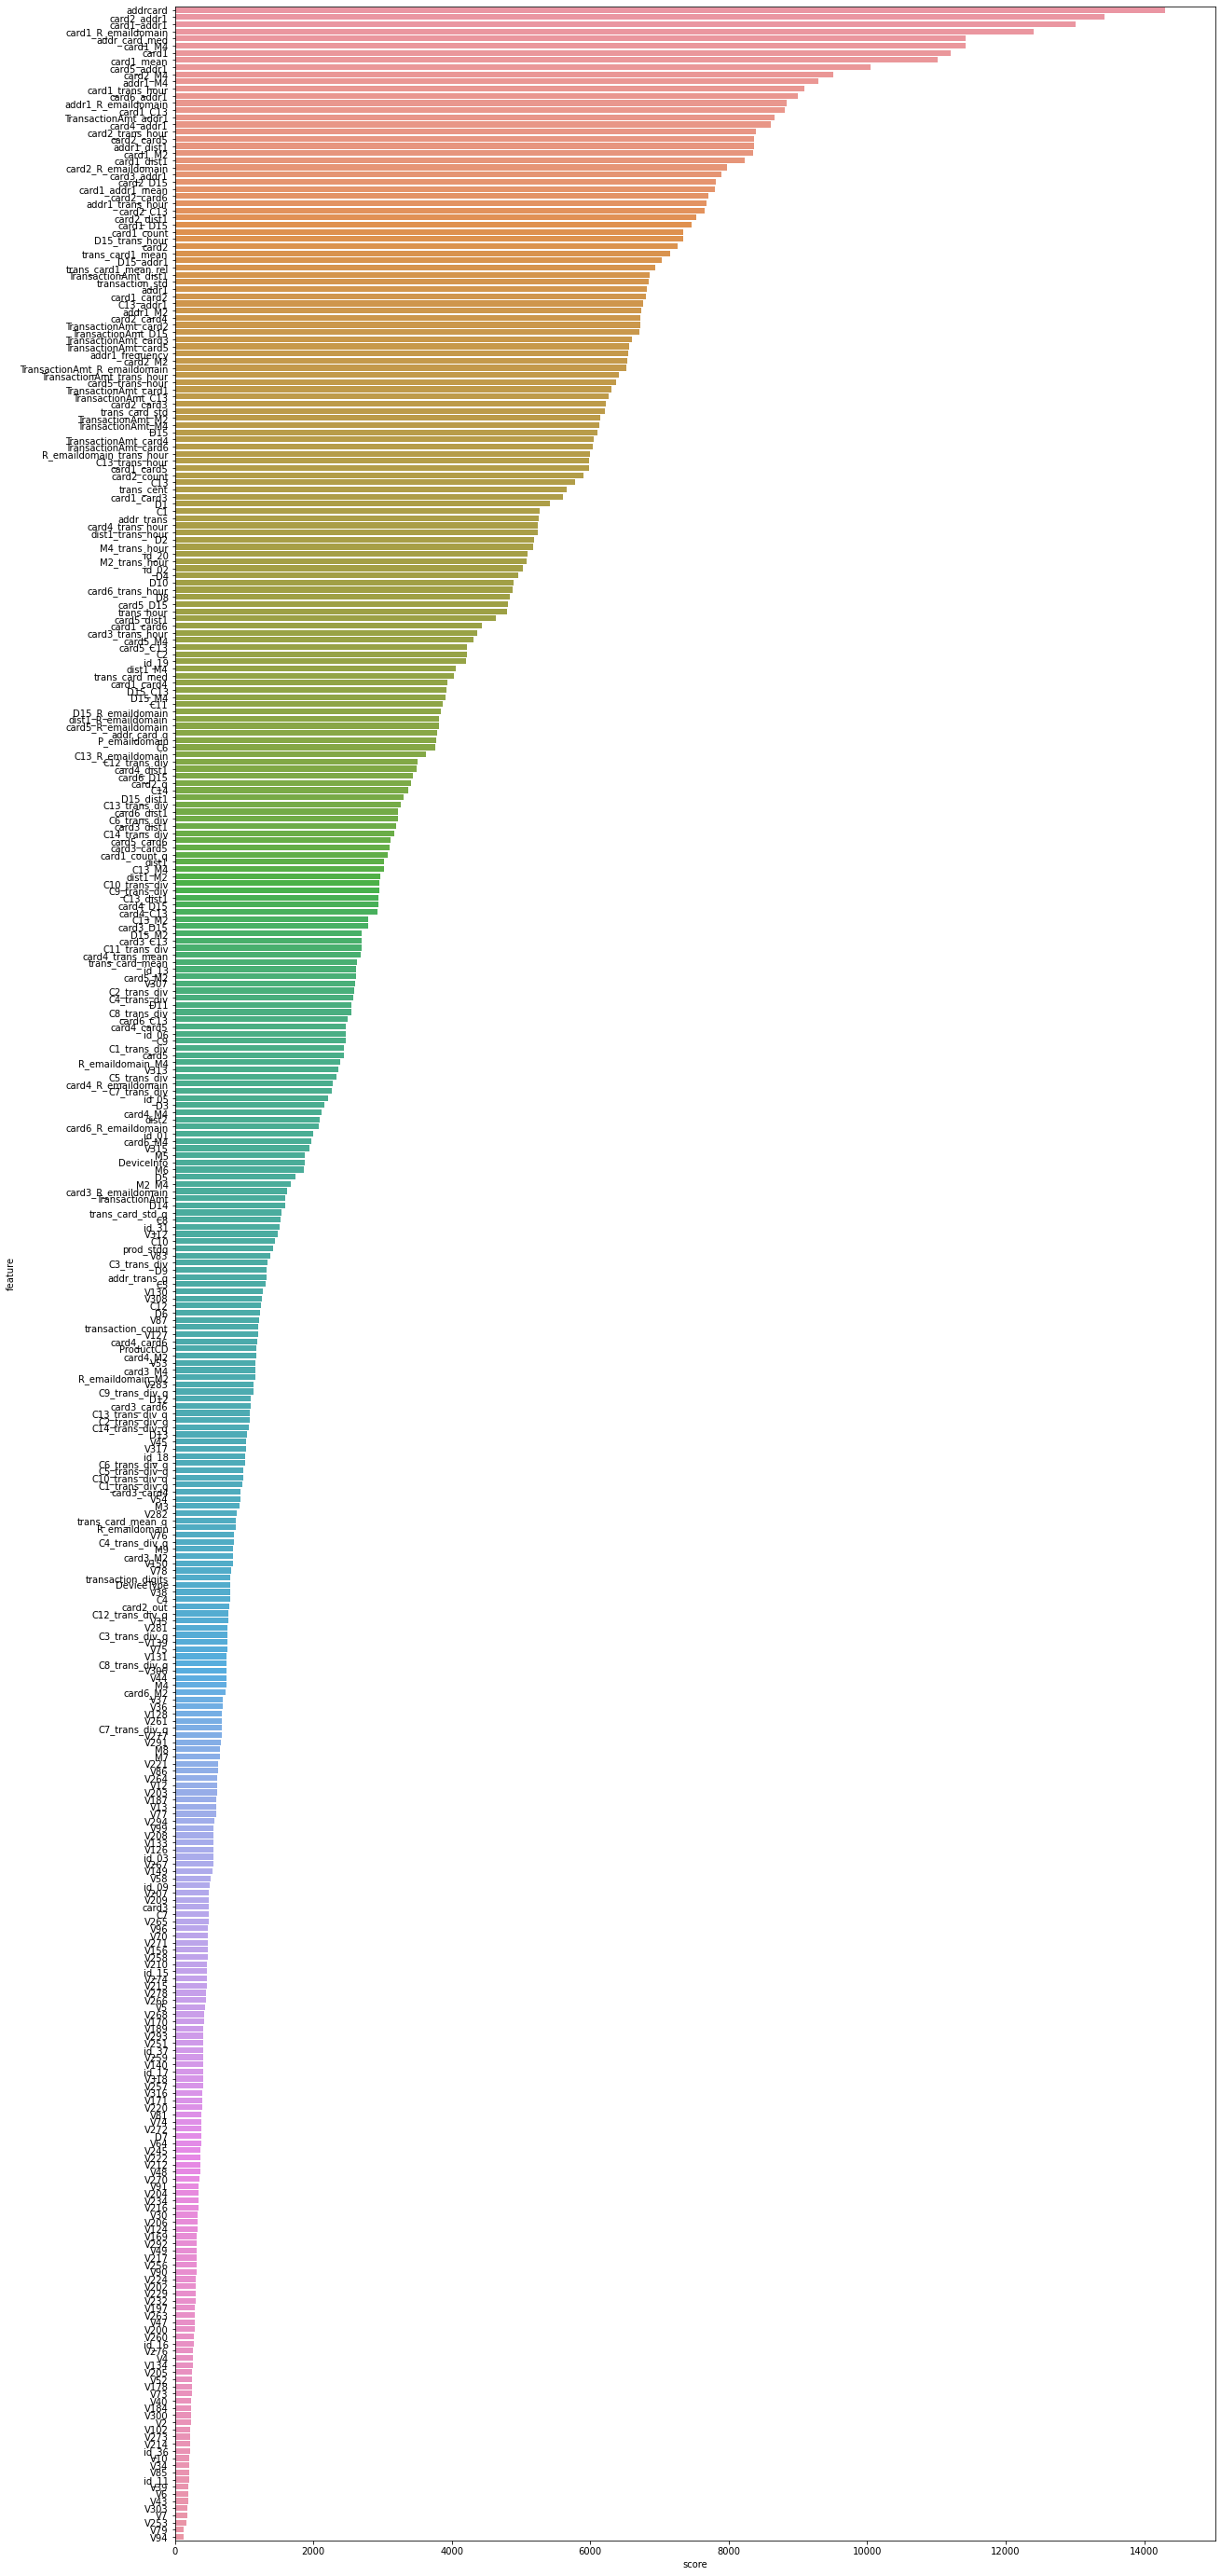

In [82]:
df = pd.DataFrame({"feature":features, "score":clf.feature_importances_}).sort_values(by='score', ascending=False).reset_index()

_, ax = plt.subplots(figsize=(20, 50))
sns.barplot(y='feature', x='score', data=df, ax=ax)